## Demo for Pytorch implementation of baseline

In [1]:
import sys

# Add main code-base to path
sys.path.append('../')

from utils import *
from model import ImgSegRefExpModel
import torch


import sys
import skimage.io
import numpy as np
import tensorflow as tf
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# input image and query text
im_file = './38100.jpg'
query = 'sky above the bridge'

# trained model
pretrained_model_file = "text_objseg_pretrained_torch_converted_with_lstm.pt"
vocab_file = './vocabulary_referit.txt'

In [3]:
# Load vocabulary
vocab_dict = load_vocab_dict_from_file(vocab_file)

# Load model and weights
model = ImgSegRefExpModel(mlp_hidden=500, vocab_size=8803, emb_size=1000, lstm_hidden_size=1000)
pre_trained = torch.load(pretrained_model_file)
model.load_state_dict(pre_trained)

In [4]:
set(model.state_dict().keys()).difference(set(pre_trained.keys()))

set()

### Run on sample image

In [14]:
# Load the model
# Model Param
T = 20
N = 1
input_H = 512; featmap_H = (input_H // 32)
input_W = 512; featmap_W = (input_W // 32)
num_vocab = 8803
embed_dim = 1000
lstm_dim = 1000
mlp_hidden_dims = 500

channel_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

# Run on the input image and query text
text_seq_val = np.zeros((T, N), dtype=np.float32)
imcrop_val = np.zeros((N, input_H, input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)

# Makes it uint8
processed_im = skimage.img_as_ubyte(resize_and_pad(im, input_H, input_W))
print(processed_im.dtype)

imcrop_val[0, :] = processed_im.astype(np.float32) - channel_mean
print(imcrop_val.dtype)

text_seq_val[:, 0] = preprocess_sentence(query, vocab_dict, T)
print(text_seq_val.dtype)

imcrop_val = torch.Tensor(imcrop_val).permute(0, 3, 1, 2) 
text_seq_val = torch.LongTensor(text_seq_val).t() 

uint8
float32
float32


In [15]:
print(imcrop_val.shape)
print(text_seq_val.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 20])


In [16]:
# Forward pass to get response map
output_mask = model((imcrop_val, text_seq_val))

print("Mask shape", output_mask.shape)
# output_mask = output_mask.permute(0, 2, 3, 1)
output_mask = output_mask.squeeze(0)
output_mask = output_mask.squeeze(0)
print("Mask shape squeezed", output_mask.shape)

# scores_val = np.squeeze(sess.run(scores, feed_dict={text_seq_batch: text_seq_val,
#                                                     imcrop_batch: imcrop_val}))

# Final prediction
prediction = resize_and_crop(output_mask.cpu().detach().numpy() > 0, * im.shape[:2]).astype(np.bool)

torch.Size([1, 1000, 16, 16])
16 16
torch.Size([1, 1, 16, 16])
Mask shape torch.Size([1, 1, 512, 512])
Mask shape squeezed torch.Size([512, 512])


In [8]:
prediction

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

query text = 'sky above the bridge'


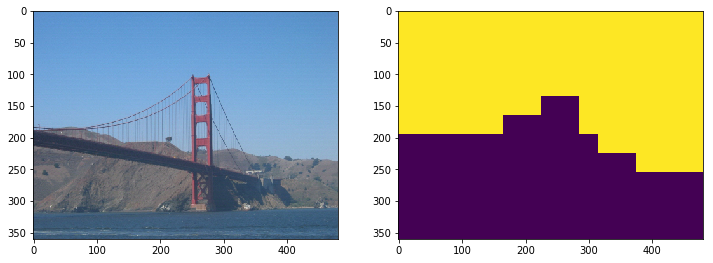

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(prediction)

print("query text = '%s'" % query)